In [1]:
!pip install -q keras-cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 48.6 MB/s eta 0:00:00


In [3]:
!pip install -q tf2onnx onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 455.8/455.8 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 114.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 15.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.17.1 requires protobuf<6.0.0,>=4.25.2; python_version >= "3.11", but you have protobuf 3.20.3 which is incompatible.
ydf 0.11.0 requires protobuf<6.0.0,>=5.29.1, but you have protobuf 3.20.3 which is incompatible.
grpcio-status 1.71.0 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 3.20.3 which is incompatible.


In [9]:
import os
import shutil
import random
from collections import defaultdict, Counter
import zipfile

from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.mixed_precision import set_global_policy
from transformers import ViTForImageClassification, ViTFeatureExtractor
from transformers import TrainingArguments, Trainer


from tensorflow.keras.applications import (
    InceptionV3,
    ResNet50,
    DenseNet121,
    EfficientNetB0
)

import keras_cv

from google.colab import drive

In [7]:
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
set_global_policy('mixed_float16')

In [11]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    zoom_range=0.05,
    brightness_range=[0.9, 1.1],
    shear_range=5,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/LungCancer_after/train',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/LungCancer_after/val',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical'
)

test_generator = val_test_datagen.flow_from_directory(
    '/content/drive/MyDrive/LungCancer_after/test',
    target_size=(224, 224),
    batch_size=64,
    class_mode='categorical',
    shuffle=False
)


Found 12000 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.
Found 1500 images belonging to 3 classes.


In [13]:
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

base_model.trainable = True
# Freeze bottom layers only:
for layer in base_model.layers[:-50]:
    layer.trainable = False

output = GlobalAveragePooling2D()(base_model.output)
output = Dropout(0.5)(output)
output = Dense(512, activation='relu')(output)
output = Dropout(0.3)(output)
output = Dense(3, activation='softmax')(output)

model_densenet = Model(inputs=base_model.input, outputs=output)

model_densenet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('best_densenet121_model.h5', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)
]

history_densenet = model_densenet.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 22s/step - accuracy: 0.7372 - loss: 0.6157 

188/188 ━━━━━━━━━━━━━━━━━━━━ 4951s 26s/step - accuracy: 0.7379 - loss: 0.6143 - val_accuracy: 0.9593 - val_loss: 0.0989 - learning_rate: 1.0000e-04
Epoch 2/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9457 - loss: 0.1405

188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9457 - loss: 0.1405 - val_accuracy: 0.9827 - val_loss: 0.0460 - learning_rate: 1.0000e-04
Epoch 3/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9676 - loss: 0.0850

188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9676 - loss: 0.0850 - val_accuracy: 0.9880 - val_loss: 0.0287 - learning_rate: 1.0000e-04
Epoch 4/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9797 - loss: 0.0541

188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9797 - loss: 0.0540 - val_accuracy: 0.9900 - val_loss: 0.0270 - learning_rate: 1.0000e-04
Epoch 5/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9860 - loss: 0.0376

188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9860 - loss: 0.0377 - val_accuracy: 0.9967 - val_loss: 0.0079 - learning_rate: 1.0000e-04
Epoch 6/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9904 - loss: 0.0258

188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9904 - loss: 0.0258 - val_accuracy: 0.9980 - val_loss: 0.0078 - learning_rate: 1.0000e-04
Epoch 7/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9929 - loss: 0.0205

188/188 ━━━━━━━━━━━━━━━━━━━━ 207s 1s/step - accuracy: 0.9929 - loss: 0.0204 - val_accuracy: 0.9980 - val_loss: 0.0054 - learning_rate: 1.0000e-04
Epoch 8/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9948 - loss: 0.0155 - val_accuracy: 0.9980 - val_loss: 0.0075 - learning_rate: 1.0000e-04
Epoch 9/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9959 - loss: 0.0120

188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9959 - loss: 0.0120 - val_accuracy: 0.9993 - val_loss: 0.0031 - learning_rate: 1.0000e-04
Epoch 10/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9971 - loss: 0.0083

188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9971 - loss: 0.0083 - val_accuracy: 0.9993 - val_loss: 0.0024 - learning_rate: 1.0000e-04
Epoch 11/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9974 - loss: 0.0078

188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9974 - loss: 0.0078 - val_accuracy: 0.9993 - val_loss: 0.0022 - learning_rate: 1.0000e-04
Epoch 12/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9972 - loss: 0.0085

188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9972 - loss: 0.0085 - val_accuracy: 1.0000 - val_loss: 0.0010 - learning_rate: 1.0000e-04
Epoch 13/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 202s 1s/step - accuracy: 0.9980 - loss: 0.0069 - val_accuracy: 0.9987 - val_loss: 0.0023 - learning_rate: 1.0000e-04
Epoch 14/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9982 - loss: 0.0070 - val_accuracy: 0.9993 - val_loss: 0.0019 - learning_rate: 1.0000e-04
Epoch 15/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9973 - loss: 0.0085
Epoch 15: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9973 - loss: 0.0085 - val_accuracy: 0.9993 - val_loss: 0.0012 - learning_rate: 1.0000e-04
Epoch 16/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9988 - loss: 0.0037

188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9988 - loss: 0.0037 - val_accuracy: 0.9993 - val_loss: 7.4808e-04 - learning_rate: 2.0000e-05
Epoch 17/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 204s 1s/step - accuracy: 0.9980 - loss: 0.0053 - val_accuracy: 0.9993 - val_loss: 0.0012 - learning_rate: 2.0000e-05
Epoch 18/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9986 - loss: 0.0031

188/188 ━━━━━━━━━━━━━━━━━━━━ 206s 1s/step - accuracy: 0.9986 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 7.4592e-04 - learning_rate: 2.0000e-05
Epoch 19/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.9982 - loss: 0.0050
Epoch 19: ReduceLROnPlateau reducing learning rate to 3.999999898951501e-06.
188/188 ━━━━━━━━━━━━━━━━━━━━ 203s 1s/step - accuracy: 0.9982 - loss: 0.0050 - val_accuracy: 0.9993 - val_loss: 7.5093e-04 - learning_rate: 2.0000e-05
Epoch 20/20
188/188 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9998 - loss: 0.0017 - val_accuracy: 0.9993 - val_loss: 9.1301e-04 - learning_rate: 4.0000e-06


24/24 ━━━━━━━━━━━━━━━━━━━━ 728s 31s/step


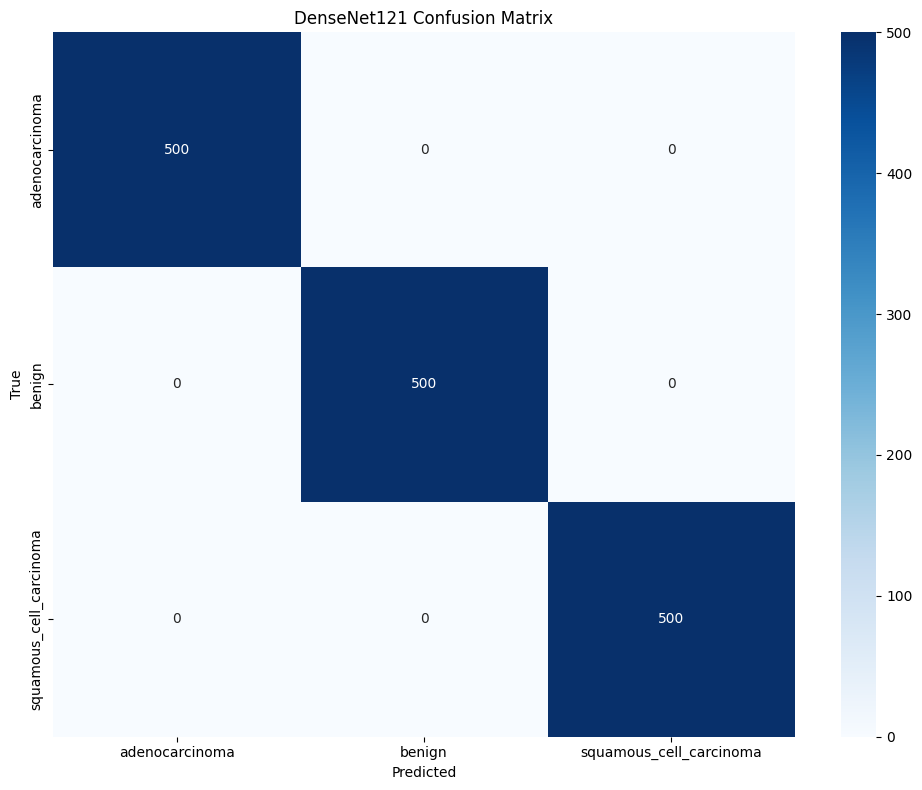

                         precision    recall  f1-score   support

         adenocarcinoma       1.00      1.00      1.00       500
                 benign       1.00      1.00      1.00       500
squamous_cell_carcinoma       1.00      1.00      1.00       500

               accuracy                           1.00      1500
              macro avg       1.00      1.00      1.00      1500
           weighted avg       1.00      1.00      1.00      1500



In [15]:
y_pred_densenet = model_densenet.predict(test_generator)
y_pred_densenet_classes = np.argmax(y_pred_densenet, axis=1)
y_true = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(y_true, y_pred_densenet_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.title("DenseNet121 Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()

print(classification_report(y_true, y_pred_densenet_classes, target_names=class_labels))


In [16]:
loss, accuracy = model_densenet.evaluate(test_generator)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 9s 362ms/step - accuracy: 1.0000 - loss: 2.2574e-04
Test Loss: 0.0001
Test Accuracy: 1.0000


In [17]:
import tf2onnx

model = model_densenet

spec = (tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name="input"),)

onnx_model, _ = tf2onnx.convert.from_keras(model, input_signature=spec, opset=13)

with open("densenet121_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

print("ONNX model saved as 'densenet121_model.onnx'")


ERROR:tf2onnx.tfonnx:rewriter <function rewrite_constant_fold at 0x7bcd9749fa60>: exception `np.cast` was removed in the NumPy 2.0 release. Use `np.asarray(arr, dtype=dtype)` instead.


ONNX model saved as 'densenet121_model.onnx'


In [19]:
import shutil

# Path to the saved ONNX file
source_path = "/content/densenet121_model.onnx"

# Destination path in your Google Drive
destination_path = "/content/drive/MyDrive/lung_cancer_models/densenet121_model.onnx"

# Copy the file
shutil.copy(source_path, destination_path)

print(f"✅ ONNX model copied to: {destination_path}")


✅ ONNX model copied to: /content/drive/MyDrive/lung_cancer_models/densenet121_model.onnx


In [18]:
import json

# Reverse the mapping
index_to_class = {
    0: "adenocarcinoma",
    1: "benign",
    2: "squamous_cell_carcinoma"
}

# Save to JSON
with open("class_names.json", "w") as f:
    json.dump(index_to_class, f)